In [11]:
import os
from preprocessing import *
BASE_PATH = os.getcwd() + "\\data"
TRAINING_PATH_AMSTERDAM= BASE_PATH + "\\training\\Amsterdam\\GE3T\\"
TRAINING_PATH_SINGAPORE= BASE_PATH + "\\training\\Singapore\\"
TRAINING_PATH_UTRECHT= BASE_PATH + "\\training\\Utrecht\\"

TEST_PATH_AMSTERDAM= BASE_PATH + "\\test\\Amsterdam\\"
TEST_PATH_SINGAPORE= BASE_PATH + "\\test\\Singapore\\"
TEST_PATH_UTRECHT= BASE_PATH + "\\test\\Utrecht\\"
TRAINING_DICT={
    "pathsFLAIR":[],
    "pathsT1":[],
    "mask" :[],
    "location":[],
    "ID":[]
}
createDictionary(TRAINING_PATH_UTRECHT, TRAINING_DICT,"Utrecht")
createDictionary(TRAINING_PATH_SINGAPORE, TRAINING_DICT, "Singapore")
createDictionary(TRAINING_PATH_AMSTERDAM, TRAINING_DICT,"Amsterdam")
print(TRAINING_DICT.get("pathsFLAIR").__getitem__(0))
print(TRAINING_DICT.get("pathsT1").__getitem__(0))
TEST_DICT={
    "pathsFLAIR":[],
    "pathsT1":[],
    "mask" :[],
    "location":[],
    "ID":[]
}
createDictionary(TEST_PATH_UTRECHT, TEST_DICT,"Utrecht")
createDictionary(TEST_PATH_SINGAPORE, TEST_DICT,"Singapore")
createDictionary(os.path.join(TEST_PATH_AMSTERDAM, "GE1T5"), TEST_DICT,"Amsterdam")
createDictionary(os.path.join(TEST_PATH_AMSTERDAM, "GE3T"), TEST_DICT,"Amsterdam")
createDictionary(os.path.join(TEST_PATH_AMSTERDAM, "Philips_VU .PETMR_01"), TEST_DICT,"Amsterdam")
print(TEST_DICT.get("pathsFLAIR").__getitem__(0))
print(TEST_DICT.get("pathsT1").__getitem__(0))


c:\Users\Aina\OneDrive\Escritorio\White-Matter-Hyperintensity-Segmentation\data\training\Utrecht\0\pre\FLAIR.nii.gz
c:\Users\Aina\OneDrive\Escritorio\White-Matter-Hyperintensity-Segmentation\data\training\Utrecht\0\pre\T1.nii.gz
c:\Users\Aina\OneDrive\Escritorio\White-Matter-Hyperintensity-Segmentation\data\test\Utrecht\1\pre\FLAIR.nii.gz
c:\Users\Aina\OneDrive\Escritorio\White-Matter-Hyperintensity-Segmentation\data\test\Utrecht\1\pre\T1.nii.gz


In [12]:
# %% environment and functions
import numpy as np
import matplotlib.pyplot as plt
import os
join = os.path.join
import torch
from segment_anything import sam_model_registry
from skimage import io, transform
import torch.nn.functional as F

# visualization functions
# source: https://github.com/facebookresearch/segment-anything/blob/main/notebooks/predictor_example.ipynb
# change color to avoid red and green
def show_mask(mask, ax, random_color=False):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        color = np.array([251/255, 252/255, 30/255, 0.6])
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    ax.imshow(mask_image)

def show_box(box, ax):
    x0, y0 = box[0], box[1]
    w, h = box[2] - box[0], box[3] - box[1]
    ax.add_patch(plt.Rectangle((x0, y0), w, h, edgecolor='blue', facecolor=(0,0,0,0), lw=2))

@torch.no_grad()
def medsam_inference(medsam_model, img_embed, box_1024, H, W):
    box_torch = torch.as_tensor(box_1024, dtype=torch.float, device=img_embed.device)
    if len(box_torch.shape) == 2:
        box_torch = box_torch[:, None, :] # (B, 1, 4)

    sparse_embeddings, dense_embeddings = medsam_model.prompt_encoder(
        points=None,
        boxes=box_torch,
        masks=None,
    )
    low_res_logits, _ = medsam_model.mask_decoder(
        image_embeddings=img_embed, # (B, 256, 64, 64)
        image_pe=medsam_model.prompt_encoder.get_dense_pe(), # (1, 256, 64, 64)
        sparse_prompt_embeddings=sparse_embeddings, # (B, 2, 256)
        dense_prompt_embeddings=dense_embeddings, # (B, 256, 64, 64)
        multimask_output=False,
        )

    low_res_pred = torch.sigmoid(low_res_logits)  # (1, 1, 256, 256)

    low_res_pred = F.interpolate(
        low_res_pred,
        size=(H, W),
        mode="bilinear",
        align_corners=False,
    )  # (1, 1, gt.shape)
    low_res_pred = low_res_pred.squeeze().cpu().numpy()  # (256, 256)
    medsam_seg = (low_res_pred > 0.5).astype(np.uint8)
    return medsam_seg


In [19]:
#%% load model and image
import nibabel
MedSAM_CKPT_PATH = "medsam_vit_b.pth"
device = "cuda:0"
medsam_model = sam_model_registry['vit_b'](checkpoint=MedSAM_CKPT_PATH)
medsam_model = medsam_model.to(device)
medsam_model.eval()

flair= os.path.join(TEST_PATH_UTRECHT, "9","pre","FLAIR.nii.gz")
img = nib.load(flair)
image_data = img.get_fdata() 
img_np = image_data[:, :, image_data.shape[2] // 2]

mask= os.path.join(TEST_PATH_UTRECHT, "9", "wmh.nii.gz")
img = nib.load(mask)
image_data = img.get_fdata() 
merged_image= np.array(image_data)
merged_image[merged_image==2]=0
image_data= merged_image


if len(img_np.shape) == 2:
    img_3c = np.repeat(img_np[:, :, None], 3, axis=-1)
else:
    img_3c = img_np

H, W, _ = img_3c.shape
print(img_3c.shape)

(240, 240, 3)


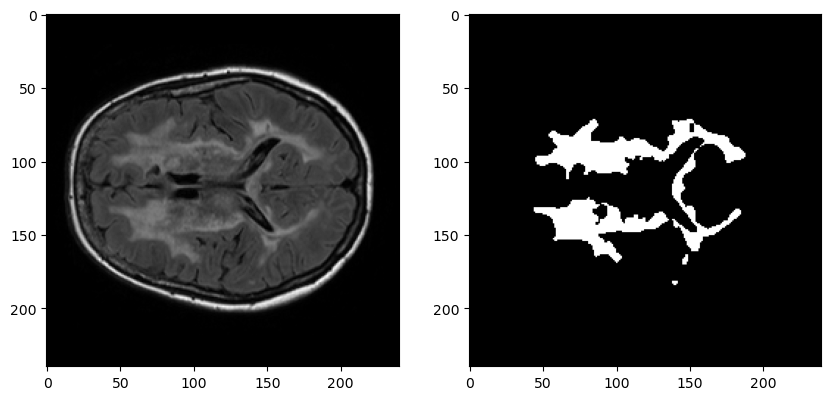

In [20]:
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].imshow(img_np, cmap='gray')
ax[1].imshow(image_data[:,:,image_data.shape[2]//2],cmap='gray')
plt.show()

In [14]:
#%% image preprocessing and model inference
img_1024 = transform.resize(img_3c, (1024, 1024), order=3, preserve_range=True, anti_aliasing=True)
img_1024 = (img_1024 - img_1024.min()) / np.clip(
     img_1024.max() - img_1024.min(), a_min=1e-8, a_max=None
 )  # normalize to [0, 1], (H, W, 3)

img_3c_vis = np.clip(img_3c, 0, 255).astype(np.uint8)

# convert the shape to (3, H, W)
img_1024_tensor = torch.tensor(img_1024).float().permute(2, 0, 1).unsqueeze(0).to(device)

box_np = np.array([[95,255, 190, 350]])
# transfer box_np t0 1024x1024 scale
box_1024 = box_np / np.array([W, H, W, H]) * 1024
with torch.no_grad():
    image_embedding = medsam_model.image_encoder(img_1024_tensor) # (1, 256, 64, 64)

medsam_seg = medsam_inference(medsam_model, image_embedding, box_1024, H, W)

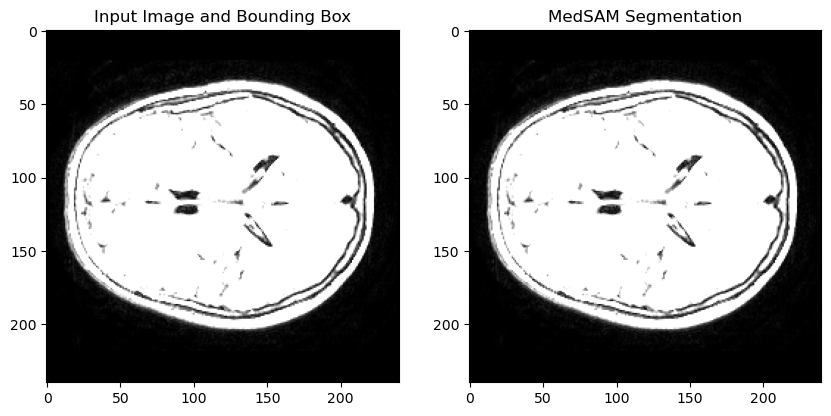

In [15]:
#%% visualize results
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].imshow(img_3c_vis)
show_box(box_np[0], ax[0])
ax[0].set_title("Input Image and Bounding Box")
ax[1].imshow(img_3c_vis)
show_mask(medsam_seg, ax[1])
show_box(box_np[0], ax[1])
ax[1].set_title("MedSAM Segmentation")
plt.show()

# FINE TUNNING